## Análisis Exploratorio de Datos


Es menester recordar que el presente trabajo tiene un enfoque de análisis estratégico respecto a los datos de los establecimientos gastronómicos del Estado de California, con el objeto de obtener insights que permitan a los potenciales clientes de EPICUREAN Data Solutions contar con la información necesaria para tomar decisiones de índole empresarial, como ser, potenciales inversiones y oportunidades de crecimiento.
Para garantizar que se proporcionen datos pertinentes y útiles para la toma de esas decisiones estratégicas, es fundamental considerar el potencial y contundencia de los datos sobre los que se impulsará el proyecto.

En el presente documento, se detalla paso por paso los procedimientos realizados para llevar adelante el análisis propuesto, el que se vale fundamentalmente de metadatos de diferentes locales gastronómicos del Estado de California, y reseñas de diferentes usuarios sobre los mismos.

En el *procedimiento de ETL* se ha realizado la carga y corrección de datos, revisando los formatos, los valores nulos y valores faltantes. También se ha realizado una limpieza de cadenas de texto, corregido los formatos erróneos, y **manejado los valores duplicados** Además, se ha hecho una inspección preliminar, para determinar qué datos podían ser de interés para este informe.

En esta nueva instancia, se procederá a un análisis de los datos seleccionadas por su relevancia, con mayor alcance que el análisis preliminar. Se intentará identificar patrones, outliers, comportamientos de los datos y su implicancia en el sector Gastronómico en el Estado de California.

In [35]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

#importamos las galerias necesarias

Procedemos a analizar, en primer lugar, la información disponible sobre locales gastronómicos del Estado de California.

In [6]:
df_metadatos = pd.read_parquet(r'C:\Users\GASTON\Desktop\PROYECTO FINAL\DATA\locales_google.parquet')
df_metadatos.head(3)

,gmap_id,name,address,latitude,longitude,category,avg_rating,num_of_reviews,state,relative_results,Service options,clasificacion,address_depurada,city,county
2,0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",34.058092,-118.292130,Korean restaurant,4.4,18,Open ⋅ Closes 6PM,"0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2c...","Takeout, Dine-in, Delivery",Dining Venue,761 S Vermont Ave,Los Angeles,Acton
6,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,Vons Chicken,"Vons Chicken, 12740 La Mirada Blvd, La Mirada,...",33.916402,-118.010855,Restaurant,4.5,18,Open ⋅ Closes 9:30PM,Sin resultados vinculados,"Outdoor seating, Curbside pickup, No-contact d...",Dining Venue,12740 La Mirada Blvd,La Mirada,Acton
761,0x80c2baf50d29bf63:0x5bd904b842b9fcc,La Potranca,"La Potranca, 12821 Venice Blvd., Los Angeles, ...",34.000181,-118.441249,Restaurant,4.2,13,Closed ⋅ Opens 10AM,"0x80c2bac345536273:0x8b015c3512788465, 0x80c2c...","Dine-in, Delivery",Dining Venue,12821 Venice Blvd.,Los Angeles,Acton


In [7]:
df_metadatos.columns

Index(['gmap_id', 'name', 'address', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'state', 'relative_results',
       'Service options', 'clasificacion', 'address_depurada', 'city',
       'county'],
      dtype='object')

Comenzando con el análisis, observamos que cada establecimiento tiene su clave identificadora (gmap_id) que permite conectarse con las reseñas obtenidas (en la tabla 'reviews' que se analizará posteriormente).
En el proceso de ETL se ha extraído información de gran relevancia geográfica, ya que, sobre la base de su dirección, se extrajo la ciudad y se asignó su Condado.

In [13]:
ciudades = df_metadatos['city'].unique().size
condados = df_metadatos['county'].unique().size
print(f'El total de ciudades con establecimientos gastronómicos es de {ciudades}, mientras que la cantidad total de condados es {condados}')

El total de ciudades con establecimientos gastronómicos es de 683, mientras que la cantidad total de condados es 58


Para continuar analizando nuestra muestra representativa, podemos evaluar la cantidad de establecimientos calificados.

In [14]:
establecimientos = df_metadatos['gmap_id'].unique().size
print(f'La cantidad total de establecimientos con reseña en el Estado de California son {establecimientos}')

La cantidad total de establecimientos con reseña en el Estado de California son 7811


Procedemos, entonces, a correlacionar estas variables/categorias. Para ello, podemos sacar un ranking de los condados con más establecimientos calificados.

In [15]:
# Top 15 de condados con más establecimientos (conteo de gmap_id)
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Mostrar resultados
print("Top 15 condados con más establecimientos:")
print(top_15_condados)

Top 15 condados con más establecimientos:
            county  num_establecimientos
0            Acton                  1817
29          Orange                   736
36       San Diego                   550
18     Los Angeles                   496
1          Alameda                   397
42     Santa Clara                   382
37   San Francisco                   341
32       Riverside                   314
35  San Bernardino                   299
9           Fresno                   213
33      Sacramento                   212
6     Contra Costa                   185
55         Ventura                   158
40       San Mateo                   152
48          Sonoma                   139


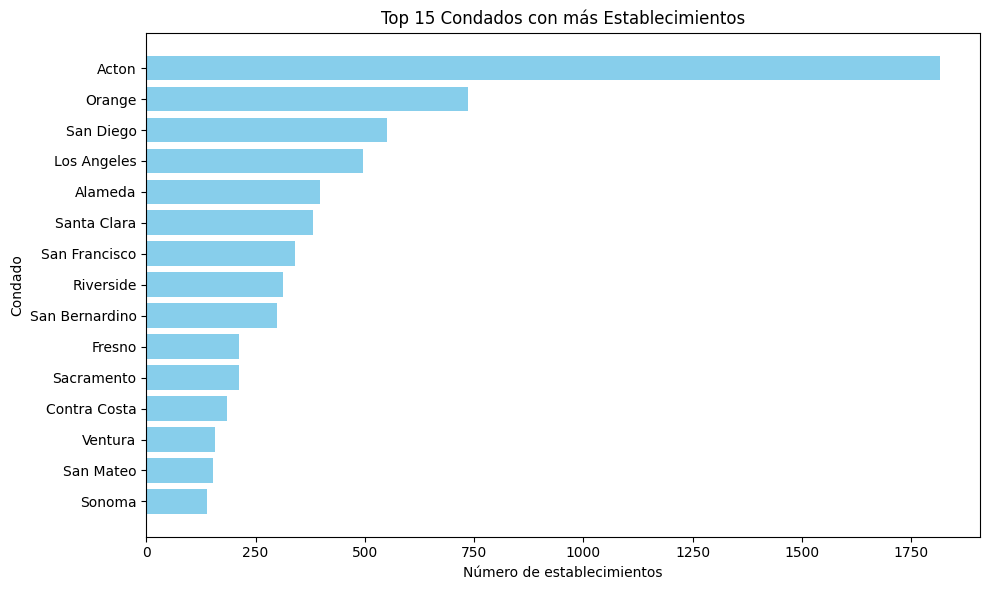

In [16]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.barh(top_15_condados['county'], top_15_condados['num_establecimientos'], color='skyblue')
plt.xlabel('Número de establecimientos')
plt.ylabel('Condado')
plt.title('Top 15 Condados con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje y para que el condado con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Veamos si hay cambios cuando realizamos el análisis por Ciudad, y no por condado.

In [18]:
# Top 15 de Ciudades con más establecimientos (conteo de gmap_id)
top_15_ciudades = df_metadatos.groupby('city')['gmap_id'].count().reset_index()
top_15_ciudades = top_15_ciudades.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_ciudades = top_15_ciudades.sort_values(by='num_establecimientos', ascending=False).head(15)


# Mostrar resultados
print("Top 15 Ciudades con más establecimientos:")
print(top_15_ciudades)

Top 15 Ciudades con más establecimientos:
              city  num_establecimientos
328    Los Angeles                   653
525  San Francisco                   341
522      San Diego                   244
528       San Jose                   176
208         Fresno                   139
513     Sacramento                   122
406        Oakland                   104
323     Long Beach                    90
543      Santa Ana                    90
35     Bakersfield                    79
499      Riverside                    73
14         Anaheim                    67
592       Stockton                    64
212   Garden Grove                    58
422         Oxnard                    55


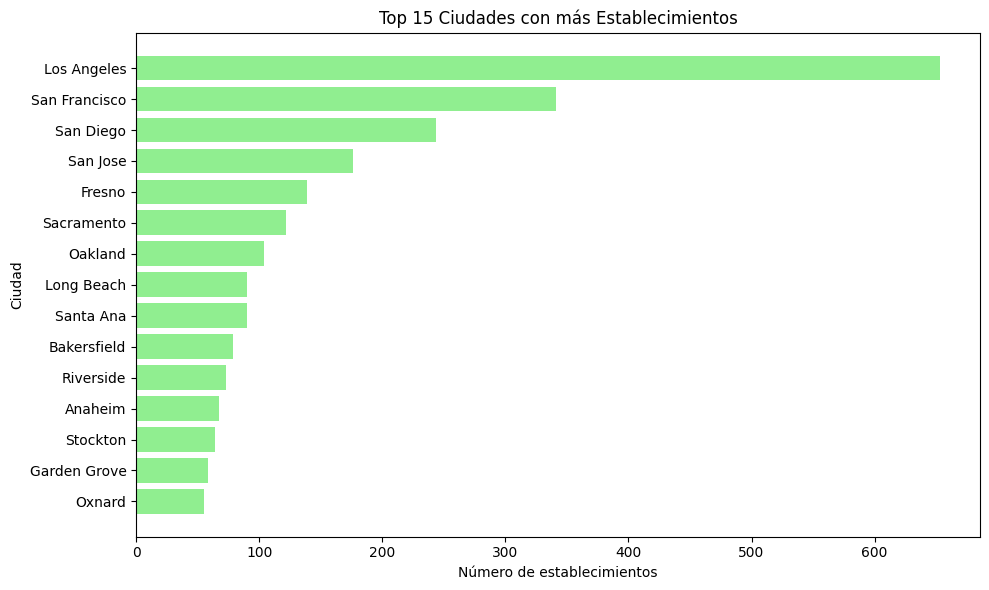

In [19]:
# Crear el histograma para el top 15 de ciudades con más establecimientos
plt.figure(figsize=(10, 6))
plt.barh(top_15_ciudades['city'], top_15_ciudades['num_establecimientos'], color='lightgreen')
plt.xlabel('Número de establecimientos')
plt.ylabel('Ciudad')
plt.title('Top 15 Ciudades con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje Y para que la ciudad con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Aquí hemos identificado que se encuentra erróneamente catalogado como "Acton" el Condado de Los Ángeles. Lo cambiaremos aquí, y se modifca el código para evitar este error en lo sucesivo en el proceso de ETL.

In [20]:
df_metadatos['county'] = df_metadatos['county'].replace('Acton', 'Los Angeles')

Ahora sí, podemos volver a realizar el análisis por Condados, para tener valores correctos

In [21]:
# Top 15 de condados con más establecimientos (conteo de gmap_id)
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Mostrar resultados
print("Top 15 condados con más establecimientos:")
print(top_15_condados)

Top 15 condados con más establecimientos:
            county  num_establecimientos
17     Los Angeles                  2313
28          Orange                   736
35       San Diego                   550
0          Alameda                   397
41     Santa Clara                   382
36   San Francisco                   341
31       Riverside                   314
34  San Bernardino                   299
8           Fresno                   213
32      Sacramento                   212
5     Contra Costa                   185
54         Ventura                   158
39       San Mateo                   152
47          Sonoma                   139
13            Kern                   137


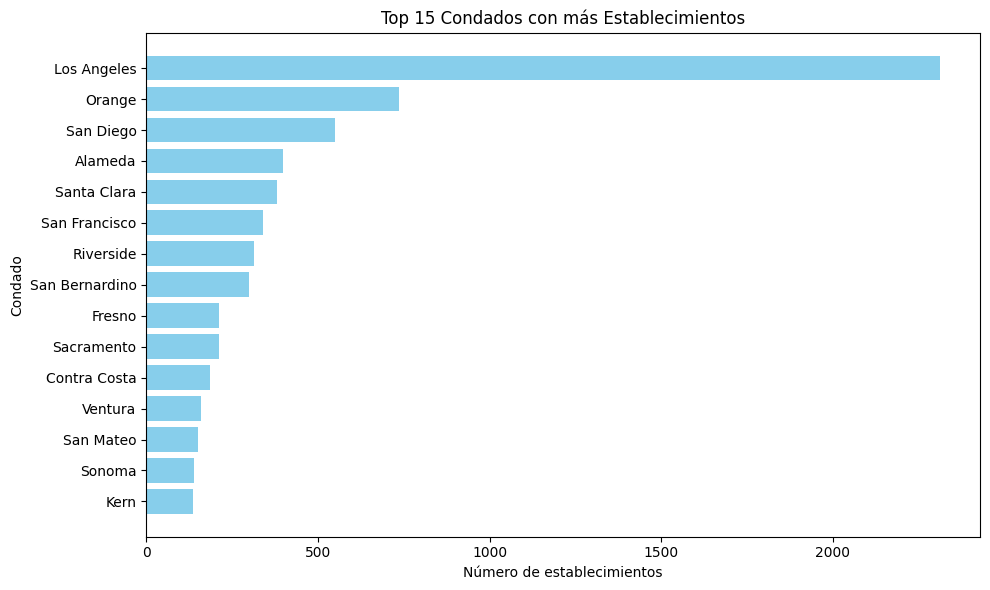

In [22]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.barh(top_15_condados['county'], top_15_condados['num_establecimientos'], color='skyblue')
plt.xlabel('Número de establecimientos')
plt.ylabel('Condado')
plt.title('Top 15 Condados con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje y para que el condado con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los datos aquieren mucho más sentido: Los Angeles tienen un enorme atractivo turístico, sin dejar de ser una localidad ampliamente industrializada, con gran desarrollo comercial. Veamos ahora cuáles son las ciudades principales de esos condados.

In [23]:
# Obtener el top 15 de condados con más establecimientos
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Crear un DataFrame para almacenar los resultados
resultados_top_ciudades = []

# Iterar sobre cada condado en el top 15
for condado in top_15_condados['county']:
    # Filtrar por el condado actual
    ciudades_en_condado = df_metadatos[df_metadatos['county'] == condado]
    
    # Obtener el top 3 de ciudades con más establecimientos
    top_ciudades = ciudades_en_condado.groupby('city')['gmap_id'].count().reset_index()
    top_ciudades = top_ciudades.rename(columns={'gmap_id': 'num_establecimientos'})
    top_ciudades = top_ciudades.sort_values(by='num_establecimientos', ascending=False).head(3)
    
    # Añadir el condado como columna en el resultado
    top_ciudades['county'] = condado
    
    # Agregar al resultado
    resultados_top_ciudades.append(top_ciudades)

# Concatenar todos los resultados en un solo DataFrame
df_resultados = pd.concat(resultados_top_ciudades, ignore_index=True)

# Mostrar resultados
print(df_resultados)

                city  num_establecimientos          county
0        Los Angeles                   653     Los Angeles
1         Long Beach                    90     Los Angeles
2           Glendale                    45     Los Angeles
3          Santa Ana                    90          Orange
4            Anaheim                    67          Orange
5       Garden Grove                    58          Orange
6          San Diego                   244       San Diego
7        Chula Vista                    40       San Diego
8           El Cajon                    25       San Diego
9            Oakland                   104         Alameda
10          Berkeley                    46         Alameda
11           Fremont                    45         Alameda
12          San Jose                   176     Santa Clara
13       Santa Clara                    32     Santa Clara
14         Sunnyvale                    27     Santa Clara
15     San Francisco                   341   San Francis

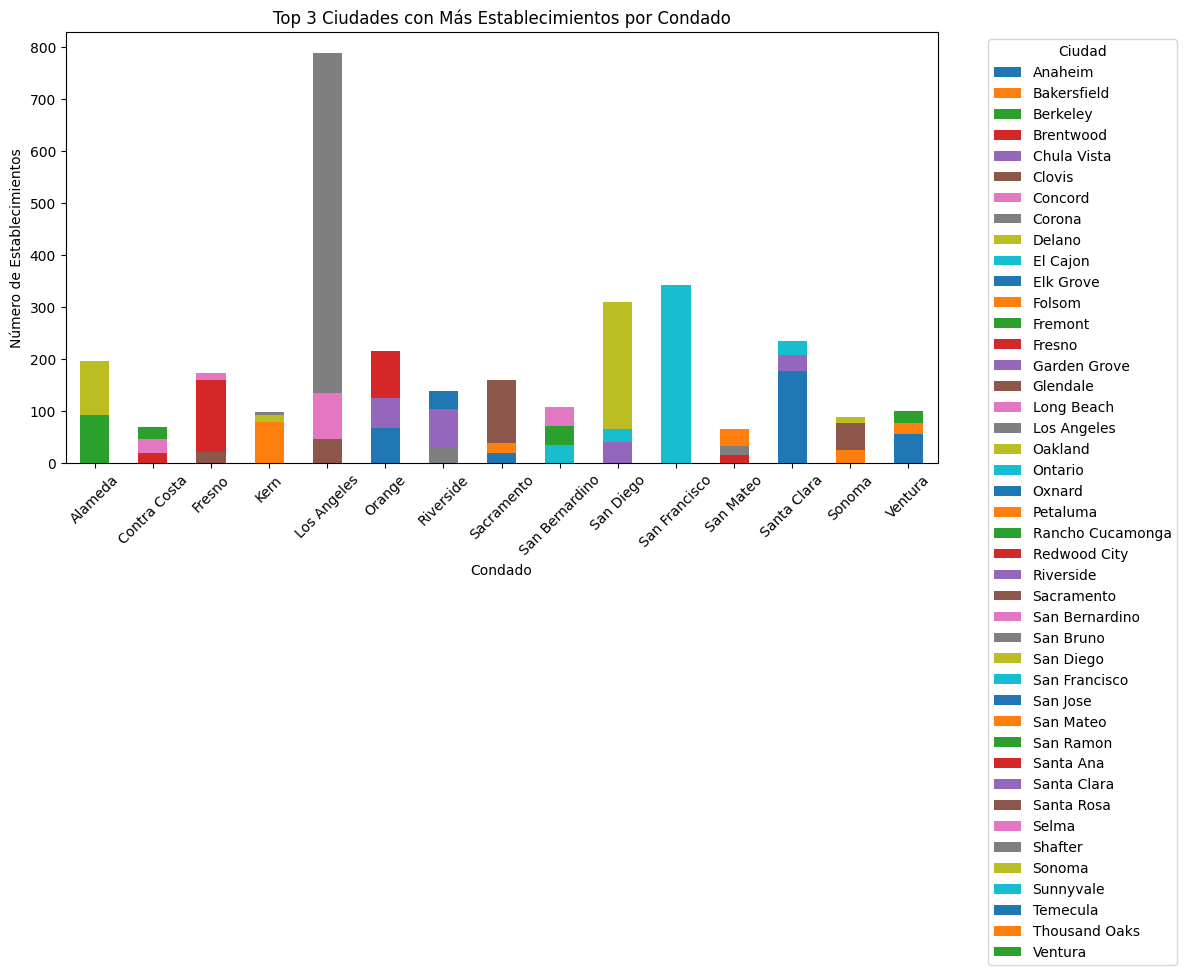

In [24]:
# Crear un DataFrame para las ciudades en formato adecuado para gráfico
df_resultados_pivot = df_resultados.pivot(index='county', columns='city', values='num_establecimientos').fillna(0)

# Crear el gráfico de columnas apiladas
plt.figure(figsize=(12, 8))
df_resultados_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), color=plt.cm.tab10.colors)

plt.title('Top 3 Ciudades con Más Establecimientos por Condado')
plt.xlabel('Condado')
plt.ylabel('Número de Establecimientos')
plt.xticks(rotation=45)
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

La distribución por ciudades, condados y la cantidad de establecimientos sirve para detectar algunos indicadores, a primera vista, dignos de ser analizados:

- Densidad Poblacional: Un mayor número de establecimientos suele correlacionarse con una población más densa, lo que significa que hay más consumidores disponibles para los negocios.

- Actividad Económica: Una alta concentración de establecimientos puede reflejar una economía local activa, con diversas oportunidades comerciales y una buena infraestructura de servicios.

- Atracción Turística: Ciudades o condados con un gran número de establecimientos, especialmente en el sector de servicios, pueden ser destinos turísticos importantes, ofreciendo restaurantes, tiendas, hoteles y actividades recreativas.

- Acceso a Recursos y Servicios: Un mayor número de establecimientos puede indicar un mejor acceso a bienes y servicios para los residentes, lo que puede mejorar la calidad de vida.

- Competencia y Diversidad: Un alto número de negocios en una área también sugiere un mercado competitivo, lo que puede beneficiar a los consumidores a través de precios más bajos y una mayor diversidad de opciones.

- Inversión y Desarrollo: Un crecimiento en el número de establecimientos puede ser indicativo de inversión en la infraestructura local y desarrollo urbano, lo que puede ser positivo para la economía de la región. 

# Categorías de los Establecimientos

Corresponde adentrarnos en el análisis de las diferentes categorías, y luego podremos realizar un análisis cruzada para obtener mejores conclusiones.

In [26]:
cant_categorias = df_metadatos['category'].unique().size
print(f'La muestra representativa presenta un total de {cant_categorias} categorías diferentes')

La muestra representativa presenta un total de 2212 categorías diferentes


In [31]:
categorias = df_metadatos['category'].unique()
categorias

array(['Korean restaurant', 'Restaurant',
       'Convenience store, ATM, Coffee shop, Coffee store, Public bathroom, Snack bar, Soft drinks shop',
       ...,
       'Pizza takeaway, American restaurant, Italian restaurant, Pizza restaurant, Vegetarian restaurant',
       'Bagel shop, Coffee shop',
       'American restaurant, Brunch restaurant, Cocktail bar, Restaurant'],
      dtype=object)

Tenemos más de 2000 categorías, lo que hace difícil un análisis a secas.

In [32]:
# Contar el número de locales por categoría usando gmap_id
conteo_categorias = df_metadatos.groupby('category')['gmap_id'].count().reset_index()

# Renombrar las columnas para mayor claridad
conteo_categorias.columns = ['category', 'num_locales']

# Ordenar las categorías por el número de locales en orden descendente
conteo_categorias = conteo_categorias.sort_values(by='num_locales', ascending=False)

# Mostrar las categorías ordenadas
print(conteo_categorias)

                                               category  num_locales
1685                                         Restaurant          948
1332                                 Mexican restaurant          553
1930  Sandwich shop, Caterer, Fast food restaurant, ...          348
112                                              Bakery          274
333                                                Cafe          235
...                                                 ...          ...
781   Ecuadorian restaurant, Bar, Family restaurant,...            1
780   Eclectic restaurant, Caterer, Deli, Restaurant...            1
779                             East African restaurant            1
778   Dumpling restaurant, Chinese restaurant, Chine...            1
2211  Wok restaurant, Asian fusion restaurant, Asian...            1

[2212 rows x 2 columns]


Analicemos las categorías principales, con más número de locales.

In [33]:
# Obtener el top 20 de categorías
top_20_categorias = conteo_categorias.head(20)

# Mostrar el top 20 de categorías
print(top_20_categorias)

                                               category  num_locales
1685                                         Restaurant          948
1332                                 Mexican restaurant          553
1930  Sandwich shop, Caterer, Fast food restaurant, ...          348
112                                              Bakery          274
333                                                Cafe          235
568                                         Coffee shop          197
500                                  Chinese restaurant          171
1572                                   Pizza restaurant          123
2164                              Vietnamese restaurant           79
2066                                    Taco restaurant           76
592   Coffee shop, Breakfast restaurant, Cafe, Coffe...           74
1168                                Japanese restaurant           69
1950                                 Seafood restaurant           64
606       Coffee shop, Cafe, Coffe

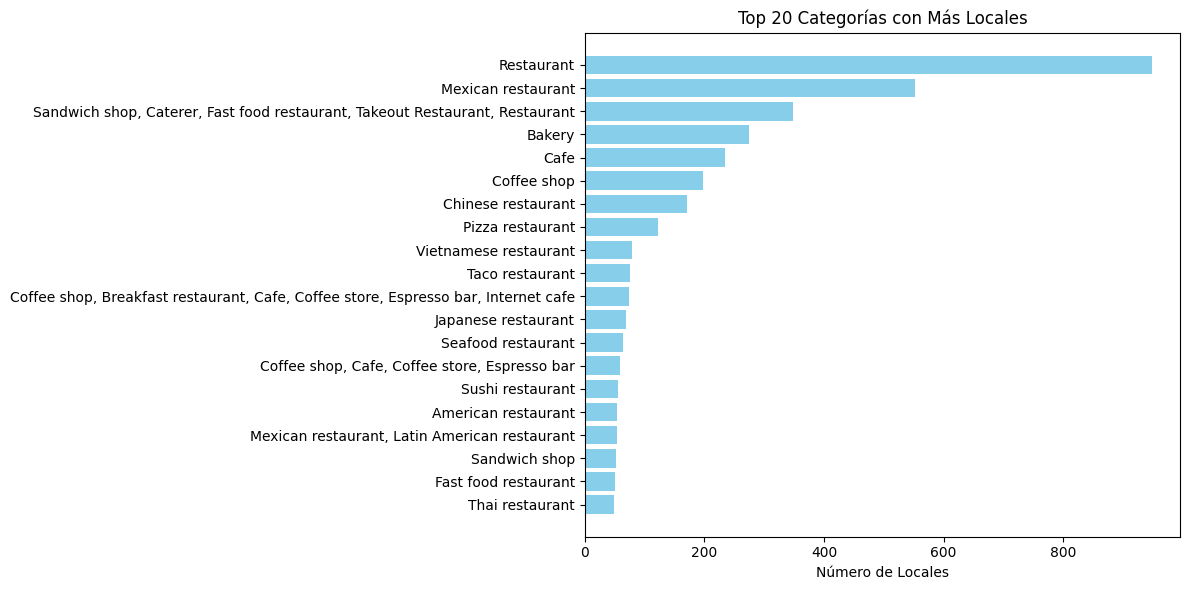

In [34]:
import matplotlib.pyplot as plt

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.barh(top_20_categorias['category'], top_20_categorias['num_locales'], color='skyblue')
plt.xlabel('Número de Locales')
plt.title('Top 20 Categorías con Más Locales')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la categoría con más locales en la parte superior
plt.tight_layout()

# Mostrar el gráfico
plt.show()


La categoría principal es 'Restaurant', y da cuenta de un establecimiento con servicio de atención en el local, aunque no exclusivamente. Veamos hora las palabras que más se repiten dentro de estos establecimientos.

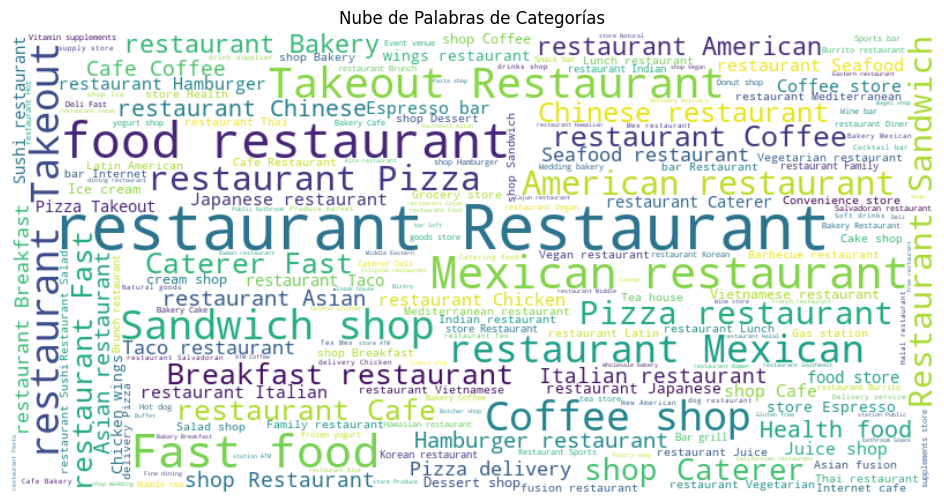

In [36]:
# Unir todas las categorías en un solo string
text = ' '.join(df_metadatos['category'].astype(str))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Nube de Palabras de Categorías')
plt.show()


Se pueden analizar en profundidad los servicios que se indican en la categoría del establecimiento.

In [38]:
# Lista de palabras clave para filtrar
palabras_clave = ['restaurant', 'delivery', 'takeout', 'pickup']

# Filtrar las categorías que contienen alguna de las palabras clave (sin distinción entre mayúsculas y minúsculas)
filtro_categorias = df_metadatos['category'].str.contains('|'.join(palabras_clave), case=False)

# Contar el número de categorías filtradas
conteo_categorias_filtradas = df_metadatos[filtro_categorias]['category'].nunique()

# Mostrar el conteo
print(f"De todos los registros, un total de {conteo_categorias_filtradas} indican el servicio.")


De todos los registros, un total de 1864 indican el servicio.


In [40]:
# Inicializar un diccionario para contar las apariciones de cada palabra clave
conteo_palabras = {palabra: 0 for palabra in palabras_clave}

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Contar las apariciones de cada palabra clave en las categorías
for palabra in palabras_clave:
    conteo_palabras[palabra] = categorias_bajas.str.count(palabra).sum()

# Mostrar los resultados
for palabra, conteo in conteo_palabras.items():
    print(f"La palabra '{palabra}' aparece {conteo} veces en las categorías.")


La palabra 'restaurant' aparece 11881 veces en las categorías.
La palabra 'delivery' aparece 451 veces en las categorías.
La palabra 'takeout' aparece 973 veces en las categorías.
La palabra 'pickup' aparece 0 veces en las categorías.


In [41]:
# Inicializar un diccionario para contar los registros por palabra clave
conteo_registros = {palabra: 0 for palabra in palabras_clave}

# Contar registros donde cada palabra clave aparece al menos una vez
for palabra in palabras_clave:
    conteo_registros[palabra] = categorias_bajas.str.contains(palabra).sum()

# Mostrar los resultados
for palabra, conteo in conteo_registros.items():
    print(f"La palabra '{palabra}' aparece en {conteo} registros de categorías.")


La palabra 'restaurant' aparece en 6379 registros de categorías.
La palabra 'delivery' aparece en 391 registros de categorías.
La palabra 'takeout' aparece en 919 registros de categorías.
La palabra 'pickup' aparece en 0 registros de categorías.


Ahora realizaremos ese análisis, respecto a los tipos de comida ofrecidos

In [42]:
# Definir los grupos de palabras clave
grupos_palabras = {
    'cafe_coffee_espresso': ['cafe', 'coffee', 'espresso'],
    'pizza': ['pizza'],
    'japanese': ['japanese'],
    'sandwich': ['sandwich'],
    'taco_mexican': ['taco', 'mexican'],
    'indian': ['indian'],
    'chinese': ['chinese'],
    'vegetarian': ['vegetarian'],
    'chicken': ['chicken'],
    'burger_hamburger': ['burger', 'hamburger'],
    'salad': ['salad'],
    'soup': ['soup'],
    'dessert': ['dessert']
}

# Inicializar un diccionario para contar los registros por grupo de palabras clave
conteo_registros_grupos = {grupo: 0 for grupo in grupos_palabras.keys()}

# Convertir la columna 'category' a minúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Contar registros donde cada grupo de palabras aparece al menos una vez
for grupo, palabras in grupos_palabras.items():
    # Crear un patrón para la búsqueda
    patron = '|'.join(palabras)
    conteo_registros_grupos[grupo] = categorias_bajas.str.contains(patron).sum()

# Mostrar los resultados
for grupo, conteo in conteo_registros_grupos.items():
    print(f"El grupo '{grupo}' aparece en {conteo} registros de categorías.")


El grupo 'cafe_coffee_espresso' aparece en 1251 registros de categorías.
El grupo 'pizza' aparece en 551 registros de categorías.
El grupo 'japanese' aparece en 187 registros de categorías.
El grupo 'sandwich' aparece en 771 registros de categorías.
El grupo 'taco_mexican' aparece en 1057 registros de categorías.
El grupo 'indian' aparece en 87 registros de categorías.
El grupo 'chinese' aparece en 351 registros de categorías.
El grupo 'vegetarian' aparece en 137 registros de categorías.
El grupo 'chicken' aparece en 268 registros de categorías.
El grupo 'burger_hamburger' aparece en 255 registros de categorías.
El grupo 'salad' aparece en 112 registros de categorías.
El grupo 'soup' aparece en 40 registros de categorías.
El grupo 'dessert' aparece en 174 registros de categorías.


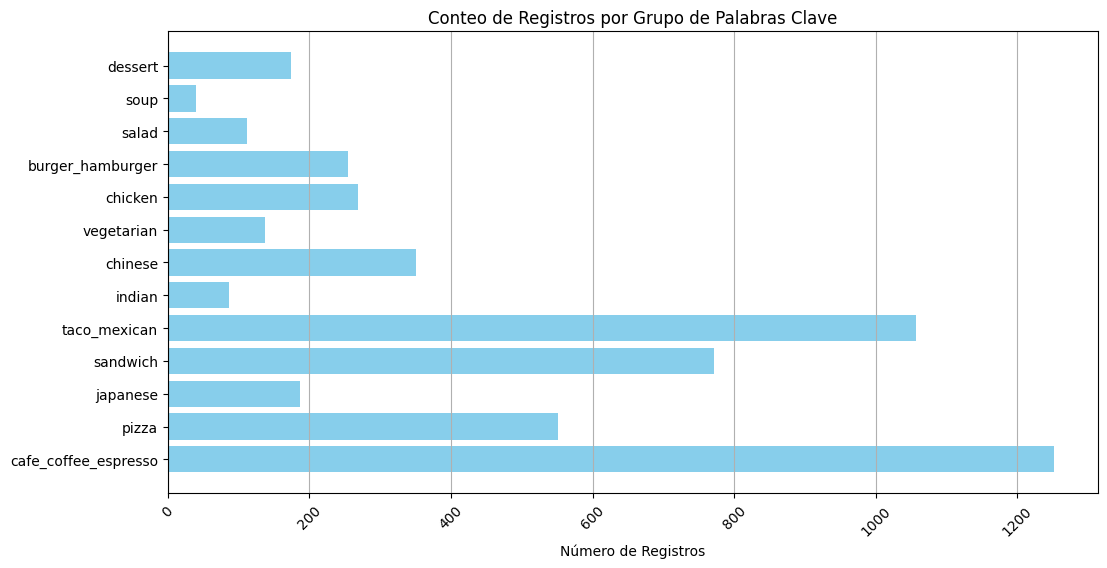

In [43]:
import matplotlib.pyplot as plt

# Crear listas para los nombres de los grupos y sus conteos
grupos = list(conteo_registros_grupos.keys())
conteos = list(conteo_registros_grupos.values())

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(grupos, conteos, color='skyblue')
plt.xlabel('Número de Registros')
plt.title('Conteo de Registros por Grupo de Palabras Clave')
plt.xticks(rotation=45)
plt.grid(axis='x')

# Mostrar el gráfico
plt.show()


Observemos si hay primacía de alguna ciudad sobre las preferencias.

In [44]:
# Inicializar un diccionario para almacenar los resultados
top_ciudades_por_grupo = {grupo: {} for grupo in grupos_palabras.keys()}

# Contar las ciudades para cada grupo de palabras clave
for grupo, palabras in grupos_palabras.items():
    patron = '|'.join(palabras)
    # Filtrar las ciudades que contienen alguna de las palabras del grupo
    ciudades_con_palabra = df_metadatos[categorias_bajas.str.contains(patron)]['city']
    # Contar las ocurrencias de cada ciudad
    conteo_ciudades = ciudades_con_palabra.value_counts().head(3)
    top_ciudades_por_grupo[grupo] = conteo_ciudades

# Mostrar los resultados
for grupo, conteo in top_ciudades_por_grupo.items():
    print(f"\nTop 3 ciudades para el grupo '{grupo}':")
    print(conteo)



Top 3 ciudades para el grupo 'cafe_coffee_espresso':
city
Los Angeles      90
San Francisco    88
San Diego        42
Name: count, dtype: int64

Top 3 ciudades para el grupo 'pizza':
city
Los Angeles    35
San Diego      12
Sacramento     12
Name: count, dtype: int64

Top 3 ciudades para el grupo 'japanese':
city
Los Angeles      18
San Francisco     8
Torrance          7
Name: count, dtype: int64

Top 3 ciudades para el grupo 'sandwich':
city
Los Angeles      39
San Diego        28
San Francisco    28
Name: count, dtype: int64

Top 3 ciudades para el grupo 'taco_mexican':
city
Los Angeles    99
Fresno         34
Santa Ana      26
Name: count, dtype: int64

Top 3 ciudades para el grupo 'indian':
city
Los Angeles      6
Sacramento       5
San Francisco    5
Name: count, dtype: int64

Top 3 ciudades para el grupo 'chinese':
city
Los Angeles    34
San Diego      13
San Jose       11
Name: count, dtype: int64

Top 3 ciudades para el grupo 'vegetarian':
city
Los Angeles      14
San Diego  

In [47]:
# Inicializar un diccionario para almacenar las preferencias por ciudad
preferencias_por_ciudad = {}

# Iterar sobre cada fila en el DataFrame de resultados
for _, fila in df_resultados.iterrows():
    ciudad = fila['city']
    condado = fila['county']
    
    # Filtrar las categorías de la ciudad
    categorias_ciudad = df_metadatos[df_metadatos['city'] == ciudad]['category']
    
    # Contar las palabras clave presentes en las categorías
    conteo_palabras = {}
    for grupo, palabras in grupos_palabras.items():
        patron = '|'.join(palabras)
        conteo_palabras[grupo] = categorias_ciudad.str.contains(patron, case=False, na=False).sum()
    
    # Almacenar el conteo de palabras en el diccionario de preferencias
    preferencias_por_ciudad[ciudad] = conteo_palabras

# Mostrar las preferencias por ciudad
for ciudad, conteo in preferencias_por_ciudad.items():
    print(f"\nPreferencias para la ciudad '{ciudad}':")
    for grupo, cantidad in conteo.items():
        print(f"  - {grupo}: {cantidad}")



Preferencias para la ciudad 'Los Angeles':
  - cafe_coffee_espresso: 90
  - pizza: 35
  - japanese: 18
  - sandwich: 39
  - taco_mexican: 99
  - indian: 6
  - chinese: 34
  - vegetarian: 14
  - chicken: 23
  - burger_hamburger: 20
  - salad: 16
  - soup: 5
  - dessert: 12

Preferencias para la ciudad 'Long Beach':
  - cafe_coffee_espresso: 12
  - pizza: 9
  - japanese: 1
  - sandwich: 9
  - taco_mexican: 13
  - indian: 0
  - chinese: 1
  - vegetarian: 0
  - chicken: 9
  - burger_hamburger: 2
  - salad: 2
  - soup: 0
  - dessert: 0

Preferencias para la ciudad 'Glendale':
  - cafe_coffee_espresso: 9
  - pizza: 8
  - japanese: 2
  - sandwich: 5
  - taco_mexican: 0
  - indian: 0
  - chinese: 0
  - vegetarian: 2
  - chicken: 2
  - burger_hamburger: 2
  - salad: 1
  - soup: 0
  - dessert: 1

Preferencias para la ciudad 'Santa Ana':
  - cafe_coffee_espresso: 13
  - pizza: 2
  - japanese: 1
  - sandwich: 6
  - taco_mexican: 26
  - indian: 0
  - chinese: 2
  - vegetarian: 0
  - chicken: 4
  -

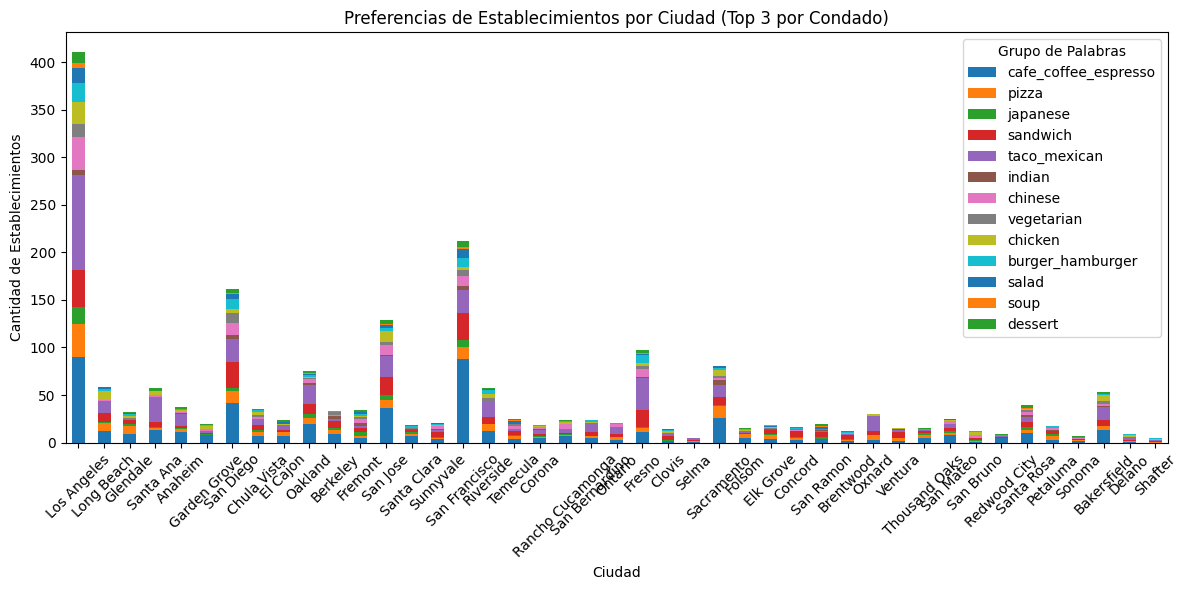

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el diccionario de preferencias a un DataFrame
preferencias_df = pd.DataFrame(preferencias_por_ciudad).T

# Resetear el índice para tener las ciudades como una columna
preferencias_df.reset_index(inplace=True)
preferencias_df.rename(columns={'index': 'city'}, inplace=True)

# Crear un gráfico de barras para cada grupo de palabras
preferencias_df.set_index('city').plot(kind='bar', stacked=True, figsize=(12, 6))

# Personalizar el gráfico
plt.title('Preferencias de Establecimientos por Ciudad (Top 3 por Condado)')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de Establecimientos')
plt.legend(title='Grupo de Palabras')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Los informes anteriores me traen a este gráfico, en el que podemos visualizar las preferencias de cada una de las principales ciudades por condados. Estas preferencias permiten identificar ciertas tendencias en el consumo.
Podemos ver, a primera vista, que ciertas ciudades como Los Angeles, San Franciso o Santa Clara tienen una gran cantidad de establecimientos con 'ensaladas' (salad) o 'sopas' (soup): aparentemente, en esas ciudades puede haber un gran mercado dispuesto al consumo saludable. También es alta la cantidad de locales de 'sandwichs' y 'café', lo que implica un consumo habitual de los mismos en centros urbanos o industriales.
La presencia de múltiples establecimientos en una categoría específica puede indicar un mercado competitivo, lo que a su vez puede beneficiar a los consumidores con mejores precios y servicios.
Identificar las preferencias menos satisfechas o las categorías en crecimiento puede ofrecer oportunidades para nuevos negocios. 
En ciudades con alta afluencia turística, las categorías populares pueden estar alineadas con las expectativas de los visitantes, lo que puede influir en el tipo de establecimientos que se establecen.

## Identificación de zonas de interés

Ya hemos visto los condados y locales con más establecimientos comerciales. Ciertamente, la media aritmética funciona como indicador: hay zonas que no tienen una cantidad de establecimientos suficientes para hablar de una zona comercial gastronómica establecida. 
El establecimiento de zonas inéditas implica un riesgo mayor en la inversión. No es una posibilidad tan remota: se pueden identificar tendencias crecientes y confrontar con la cantidad de establecimientos disponibles. No obstante, tales oportunidades escapan el marco del presente análisis:
***Este proyecto tiene como cliente objetivo empresarios o emprendedores que buscan inversiones con un riesgo moderado***. Por ello, el punto de partida es un mercado establecido con una población medianamente grande, para reducir los riesgos y garantizar un retorno de inversión mínimo.

En ese sentido, hemos de analizar geo-económicamente al Estado de California.

Si bien hay [varios informes económicos disponibles](https://es.wikipedia.org/wiki/Econom%C3%ADa_de_California), lo cierto es que en la mayoría de ellos se destaca a Estado de California como una de las economías más grandes del Mundo. De hecho, es habitual la comparación con diferentes países, en donde generalmente prevalece el Estado del suroeste norteamericano.
En búsqueda de la explicación de esta economía tan firme y consolidada, aparecen tres factores:
- Instalación y crecimiento de grandes polos tecnológicos: en el Estado de California, principalmente en Silicon Valley, se han instalado muchas empresas dedicadas a la tecnología, comunicaciones y ciencias de la computación. Esta red de empresas, seducida por programas de apoyo y beneficios impositivos, tiene una gran incidencia en la alta tasa de empleo y educación, que tiene un impacto directo en la economía regional.
- Diversidad en la oferta turística: el Estado de California cuenta con una serie de atractivos que abarcan playas, viñedos, zoológicos, parques naturales, montañas, y más. Estas atracciones, sumado a clima mediterráneo, caracterizado por veranos cálidos y secos e inviernos suaves y lluviosos, garantizan un movimiento de turistas constante, que impulsa las economías locales.
- Decisión de explotar ambos potenciales: por lo general, un Estado define la economía regional en una disputa Industria vs. Turismo. Esta tendencia se ha repetido acabadamente en muchos puntos del planeta, donde grandes espacios geográficos deben optar por una de las dos alternativas. En el caso de california, ha contribuido mucho que las empresas intenten ser cada vez más "verdes" y que, en general, se ha atraído a empresas del rubro tecnológico. Esto hizo más simple la decisión de impulsar ambos caminos, con grandes resultados.


Puede acudirse al [Análisis económico](/Data%20Analytics/Análisis%20Económico/Análisis_económico.ipynb) realizado por EPICUREAN Data Solutions para más información.

Si bien el análisis económico es preexistente a este informe, nos permite concluir cuáles son los condados que más interés nos promueven.
Comencemos por identificar los 10 condados más interesantes (económicamente) por su incidencia en el rubro industrial y/o tecnológico.

•	Santa Clara (Silicon Valley)<br>
•	San Mateo (parte de Silicon Valley)<br>
•	Alameda (Oakland, Berkeley, y centros tecnológicos)<br>
•	San Francisco (ciudad tecnológica y sede de muchas startups)<br>
•	Los Ángeles (ciudad de industrias tecnológicas y entretenimiento)<br>
•	Orange (industria tecnológica y manufactura avanzada)<br>
•	San Diego (biotecnología y desarrollo tecnológico)<br>
•	Sacramento (centro administrativo y tecnológico en crecimiento)<br>
•	Contra Costa (sector industrial y tecnológico en expansión)<br>
•	Ventura (industria aeroespacial y manufactura)<br>


Luego, podemos continuar identificando los 10 condados con más atracciones turísticas:

•	Los Ángeles (Hollywood, playas, parques temáticos)<br>
•	San Francisco (Golden Gate Bridge, Alcatraz, turismo urbano)<br>
•	San Diego (playas, zoológico, parques temáticos)<br>
•	Orange (Disneyland, playas)<br>
•	Monterey (Carmel, Big Sur, Acuario de Monterey Bay)<br>
•	Napa (región vinícola)<br>
•	Sonoma (turismo vinícola y parques naturales)<br>
•	Santa Barbara (playas, viñedos, paisajes)<br>
•	Marin (Muir Woods, Sausalito, Parque Nacional Golden Gate)<br>
•	El Dorado (Lago Tahoe, turismo de montaña y naturaleza)<br>



Por último, podemos identificar aquellos centros que ofrezcan tanto atractivos turísticos, como un gran desarrollo industrial:

•	Los Ángeles<br>
•	San Francisco<br>
•	Orange<br>
•	San Diego<br>
•	Santa Clara<br>

Estos cinco condados combinan una fuerte presencia tecnológica e industrial con destinos turísticos que atraen visitantes de todo el mundo.


Esta identificación de zonas de interés, permitirá focalizar el análisis a ciudades y condados en los que, efectivamente, podamos encontrar insights de utilidad para el objetivo de nuestro proyecto.

## Popularidad y calidad de los establecimientos gastronómicos

Procedemos al análisis de otras variables, que permitirán abarcar la popularidad y la calidad del comercio analizado. Podemos focalizarnos en las zonas de interés.
Comencemos por establecer la cantidad de reseñas, primer gran parámetro de la popularidad de los establecimientos.

**Comenzamos por los condados "urbanos" o con mayor desarrollo industrial/tech.**

In [51]:
# Filtrar el DataFrame por los condados especificados
condados_filtrados = ['Santa Clara', 'San Mateo', 'Alameda', 'San Francisco', 
                      'Los Ángeles', 'Orange', 'San Diego', 'Sacramento', 
                      'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_filtrados)]

# Calcular la suma total de num_of_reviews en los condados filtrados
suma_reseñas = df_filtrado['num_of_reviews'].sum()

print(f'La suma total de reseñas en los condados seleccionados es: {suma_reseñas}')


La suma total de reseñas en los condados seleccionados es: 469274


In [53]:
# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_filtrados)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Mostrar el resultado
print(reseñas_por_condado)

          county  num_of_reviews
2         Orange          115803
4      San Diego           90272
7    Santa Clara           75863
5  San Francisco           49806
0        Alameda           44524
3     Sacramento           42078
1   Contra Costa           18752
6      San Mateo           18546
8        Ventura           13630


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\2355246693.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado, palette='viridis')


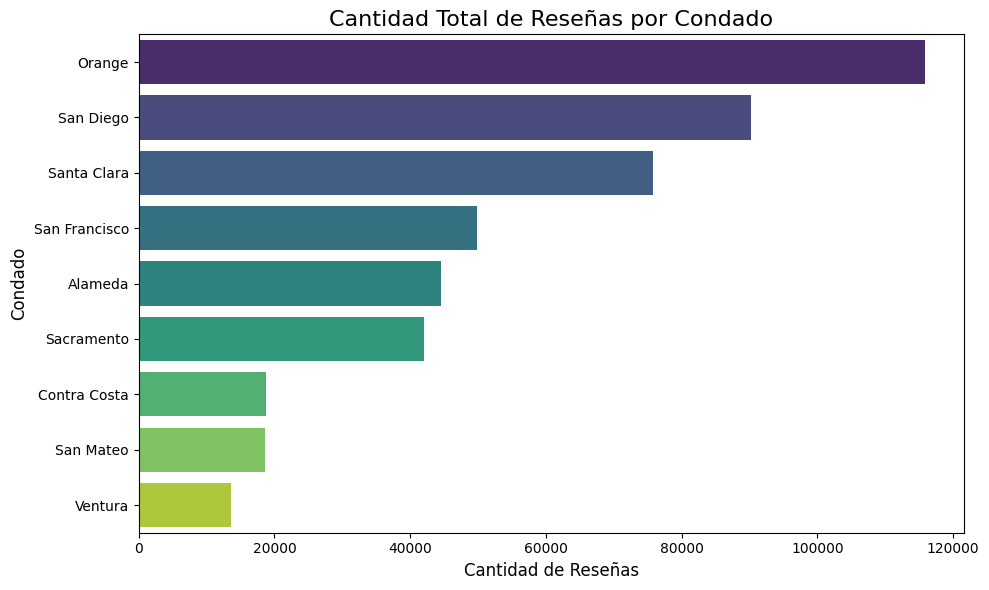

In [59]:
# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado, palette='viridis')

# Personalizar el gráfico
plt.title('Cantidad Total de Reseñas por Condado', fontsize=16)
plt.xlabel('Cantidad de Reseñas', fontsize=12)
plt.ylabel('Condado', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


La cantidad de reseñas de los condados 'industriales/tech' es de alta frecuencia. Analizando la diferencia que saca el condado de Orange, caemos en cuenta que dentro de esa zona de encuentra el popular 'Disney Anaheim Resort'. Esto no sólo aumenta la cantidad de valoraciones por su constante flujo de personas, sino que aumenta la cantidad de establecimientos vinculados a Disney World (dentro, aledaños y en camino).
Ahora podemos analizar la categoría de sus reseñas.

In [57]:
# Filtrar el DataFrame por los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_filtrados)]

# Agrupar por condado y categoría, sumando las reseñas para cada combinación
reseñas_por_condado_categoria = df_filtrado.groupby(['county', 'category'])['num_of_reviews'].sum().reset_index()

# Ordenar las reseñas dentro de cada condado
reseñas_por_condado_categoria = reseñas_por_condado_categoria.sort_values(by=['county', 'num_of_reviews'], ascending=[True, False])

# Tomar las 10 categorías con más reseñas para cada condado
top_10_categorias_por_condado = reseñas_por_condado_categoria.groupby('county').head(10).reset_index(drop=True)

# Mostrar el resultado
top_10_categorias_por_condado

,county,category,num_of_reviews
0,Alameda,Mexican restaurant,5772
1,Alameda,"Shopping mall, Grocery store, Restaurant",2448
2,Alameda,"Restaurant, American restaurant, Dessert resta...",2150
3,Alameda,"Grocery store, Cheese shop, Florist, Health fo...",1964
4,Alameda,Restaurant,1688
...,...,...,...
85,Ventura,Bakery,597
86,Ventura,"Japanese restaurant, Asian restaurant, Bar, Se...",480
87,Ventura,"Sandwich shop, Caterer, Fast food restaurant, ...",445
88,Ventura,"Fast food restaurant, Breakfast restaurant, Bu...",335


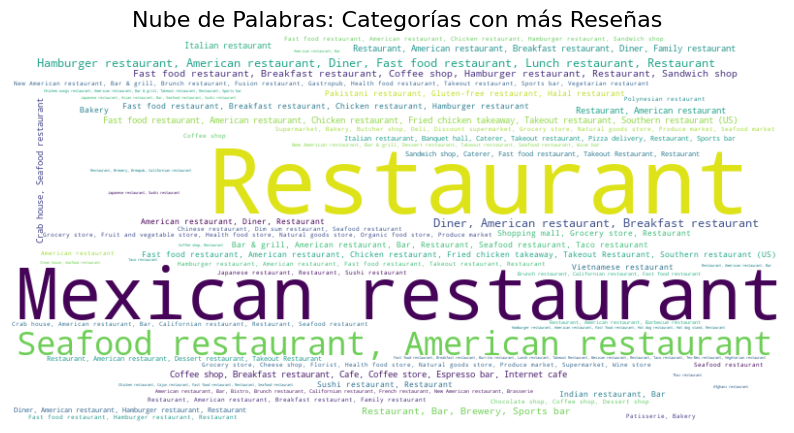

In [60]:
# Generar un diccionario con las categorías y la suma de sus reseñas
category_reseñas_dict = top_10_categorias_por_condado.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.title('Nube de Palabras: Categorías con más Reseñas', fontsize=16)
plt.show()

Como observamos que hay una gran cantidad de restaurantes con valoraciones, que tienen la categoría 'Mexican Restaurant', podemos buscar la distribución demográfica y concluir que el centro y sur del Estado de California tiene mucha población de origen latina. [Puede observarse con más detalle aquí](https://www.bbc.com/mundo/noticias-internacional-47036609).
Ahora bien: muchos de los condados seleccionados se caracterizan no sólo por su avance y desarrollo industrial, sino por sus atractivos turísticos. Avancemos con el análisis de esos condados turísticos, antes de sacar conclusiones.

In [61]:
# Filtrar los nuevos condados especificados
condados_filtrados_nuevos = ['Los Ángeles', 'San Francisco', 'San Diego', 
                               'Orange', 'Monterey', 'Napa', 'Sonoma', 
                               'Santa Barbara', 'Marin', 'El Dorado']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado_nuevo = df_metadatos[df_metadatos['county'].isin(condados_filtrados_nuevos)]

# Calcular la suma total de num_of_reviews en los condados filtrados
suma_reseñas_nueva = df_filtrado_nuevo['num_of_reviews'].sum()

print(f'La suma total de reseñas en los condados seleccionados es: {suma_reseñas_nueva}')


La suma total de reseñas en los condados seleccionados es: 305106


In [62]:
# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado_nuevo = df_metadatos[df_metadatos['county'].isin(condados_filtrados_nuevos)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado_nuevo = df_filtrado_nuevo.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado_nuevo = reseñas_por_condado_nuevo.sort_values(by='num_of_reviews', ascending=False)

# Mostrar el resultado
print(reseñas_por_condado_nuevo)

          county  num_of_reviews
4         Orange          115803
5      San Diego           90272
6  San Francisco           49806
8         Sonoma           14488
7  Santa Barbara           13251
2       Monterey           10014
3           Napa            6307
0      El Dorado            2850
1          Marin            2315


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\1521479857.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado_nuevo, palette='viridis')


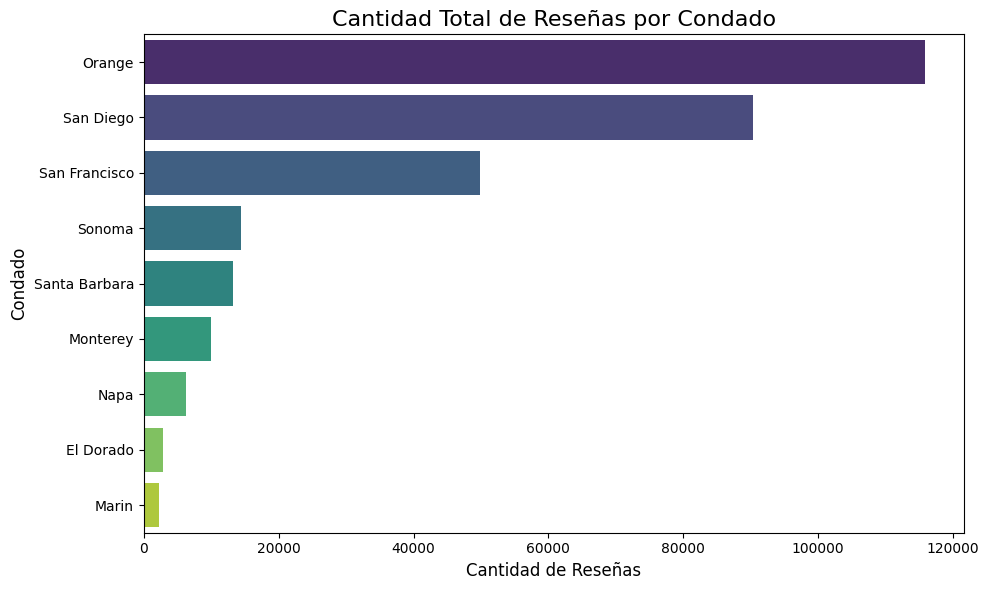

In [63]:
# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado_nuevo = df_filtrado_nuevo.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado_nuevo = reseñas_por_condado_nuevo.sort_values(by='num_of_reviews', ascending=False)

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado_nuevo, palette='viridis')

# Personalizar el gráfico
plt.title('Cantidad Total de Reseñas por Condado', fontsize=16)
plt.xlabel('Cantidad de Reseñas', fontsize=12)
plt.ylabel('Condado', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [64]:
# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado_nuevo = df_metadatos[df_metadatos['county'].isin(condados_filtrados_nuevos)]

# Agrupar por condado y categoría, sumando las reseñas para cada combinación
reseñas_por_condado_categoria_nuevo = df_filtrado_nuevo.groupby(['county', 'category'])['num_of_reviews'].sum().reset_index()

# Ordenar las reseñas dentro de cada condado
reseñas_por_condado_categoria_nuevo = reseñas_por_condado_categoria_nuevo.sort_values(by=['county', 'num_of_reviews'], ascending=[True, False])

# Tomar las 10 categorías con más reseñas para cada condado
top_10_categorias_por_condado_nuevo = reseñas_por_condado_categoria_nuevo.groupby('county').head(10).reset_index(drop=True)

# Mostrar el resultado
print(top_10_categorias_por_condado_nuevo)

       county                                           category  \
0   El Dorado                 German restaurant, Bar, Restaurant   
1   El Dorado                     Italian restaurant, Restaurant   
2   El Dorado              Japanese restaurant, Sushi restaurant   
3   El Dorado  Sandwich shop, Caterer, Fast food restaurant, ...   
4   El Dorado                                    Bar, Restaurant   
..        ...                                                ...   
85     Sonoma                  Bakery, Cookie shop, Dessert shop   
86     Sonoma               Cafe, Restaurant, Seafood restaurant   
87     Sonoma                                 Mexican restaurant   
88     Sonoma                                 Chinese restaurant   
89     Sonoma                                             Bakery   

    num_of_reviews  
0              918  
1              275  
2              245  
3              211  
4              208  
..             ...  
85             578  
86             

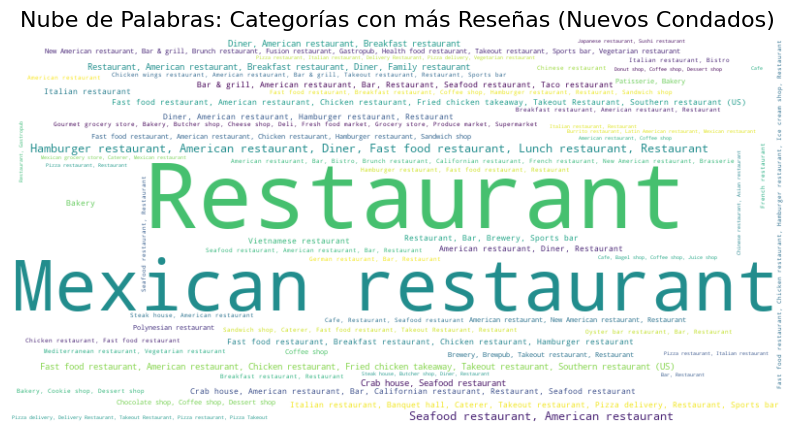

In [65]:
# Generar un diccionario con las categorías y la suma de sus reseñas para los nuevos condados
category_reseñas_dict_nuevo = top_10_categorias_por_condado_nuevo.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras
wordcloud_nueva = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_nuevo)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_nueva, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.title('Nube de Palabras: Categorías con más Reseñas (Nuevos Condados)', fontsize=16)
plt.show()

La gran presencia de población hispana una vez se impone, lo que se demuestra con la popularidad de los establecimientos de 'Mexican restaurant' en los condados turísticos. Atención: esto también puede ser un indicador de turistas latinoamericanos o 'hispano hablantes'.
Ahora bien, si dejamos de lado esa avasallante popularidad, podemos observar dos grandes tendencias: las "comidas rápidas" (burger, pizza, fast food) y las "comidas de mar" (seafood, crab house). Cabe mencionar que California limita con el Océano Pacífico, ofreciendo entre sus atractivos con populares balnearios.

**Mejoremos la clasificación**

In [66]:
# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Crear una nueva columna para clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_condado['Tipo'] = reseñas_por_condado['county'].apply(clasificar_condado)

# Agrupar por tipo de condado y sumar las reseñas
reseñas_por_tipo = reseñas_por_condado.groupby('Tipo')['num_of_reviews'].sum().reset_index()

# Mostrar el resultado
print(reseñas_por_tipo)


                        Tipo  num_of_reviews
0                   Híbridos          255881
1  Industriales/Tecnológicos          171315
2                 Turísticos           49225


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\514065865.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tipo', y='num_of_reviews', data=reseñas_por_tipo, palette='pastel')


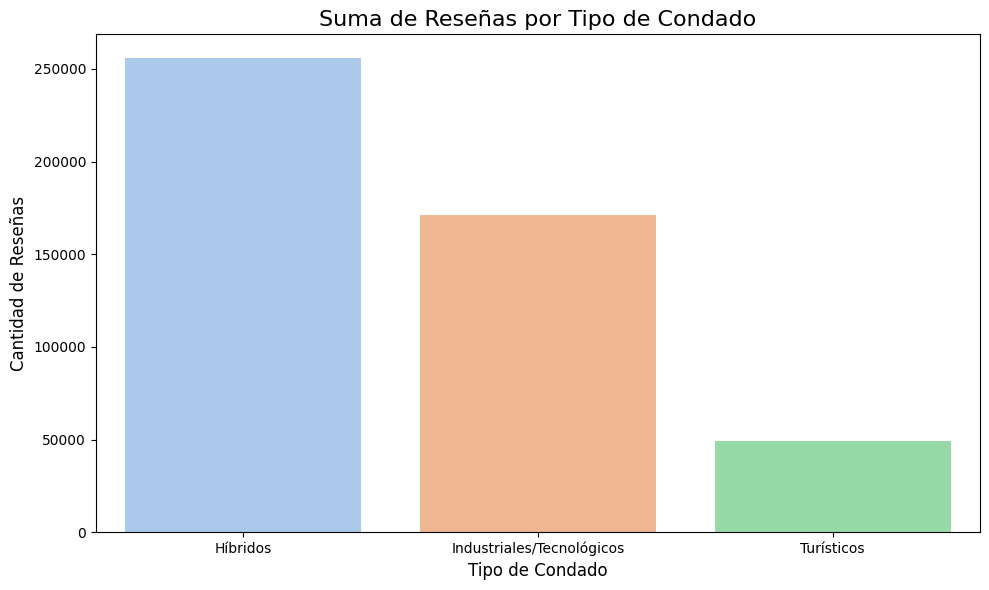

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Crear una nueva columna para clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_condado['Tipo'] = reseñas_por_condado['county'].apply(clasificar_condado)

# Agrupar por tipo de condado y sumar las reseñas
reseñas_por_tipo = reseñas_por_condado.groupby('Tipo')['num_of_reviews'].sum().reset_index()

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo', y='num_of_reviews', data=reseñas_por_tipo, palette='pastel')

# Personalizar el gráfico
plt.title('Suma de Reseñas por Tipo de Condado', fontsize=16)
plt.xlabel('Tipo de Condado', fontsize=12)
plt.ylabel('Cantidad de Reseñas', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\1024413720.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)


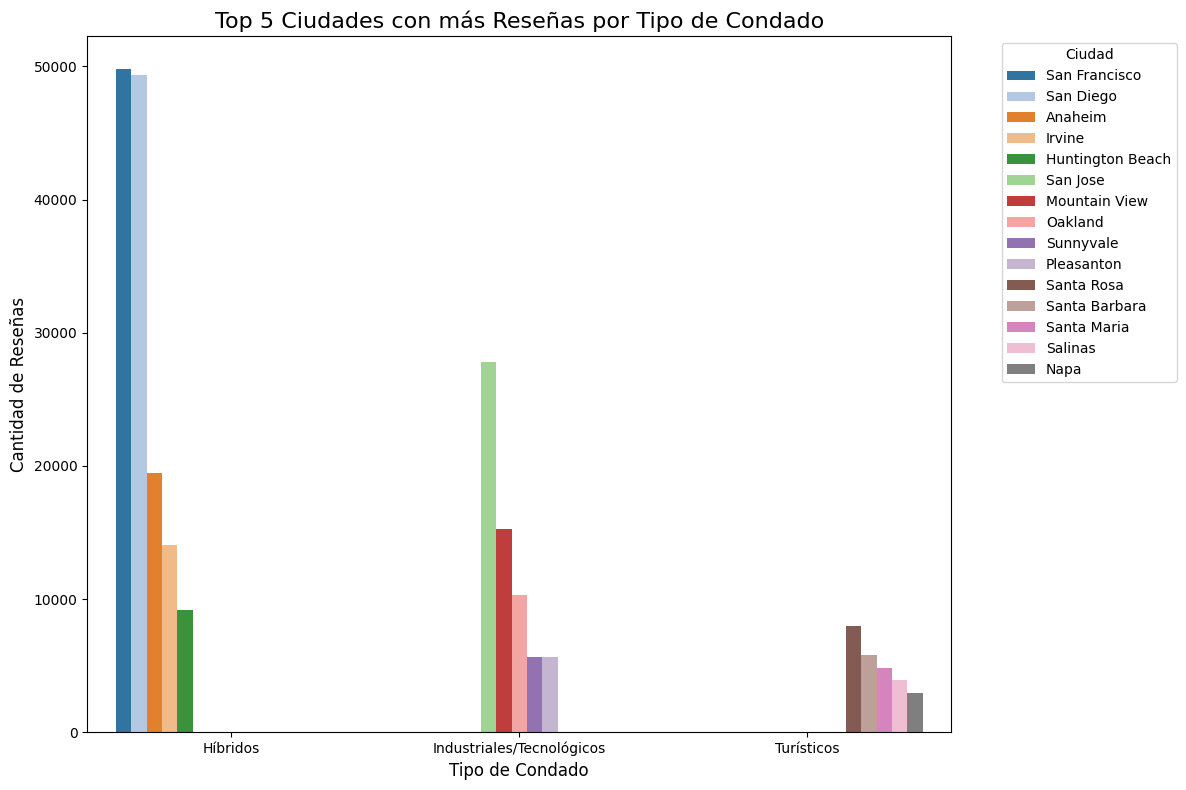

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado y ciudad, sumando las reseñas
reseñas_por_ciudad = df_filtrado.groupby(['county', 'city'])['num_of_reviews'].sum().reset_index()

# Clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_ciudad['Tipo'] = reseñas_por_ciudad['county'].apply(clasificar_condado)

# Filtrar el top 5 de ciudades con más reseñas por grupo
top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)

# Crear el gráfico de columnas apiladas
plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_ciudades_por_tipo, x='Tipo', y='num_of_reviews', hue='city', palette='tab20')

# Personalizar el gráfico
plt.title('Top 5 Ciudades con más Reseñas por Tipo de Condado', fontsize=16)
plt.xlabel('Tipo de Condado', fontsize=12)
plt.ylabel('Cantidad de Reseñas', fontsize=12)
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [71]:
# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado y ciudad, sumando las reseñas
reseñas_por_ciudad = df_filtrado.groupby(['county', 'city'])['num_of_reviews'].sum().reset_index()

# Clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_ciudad['Tipo'] = reseñas_por_ciudad['county'].apply(clasificar_condado)

# Filtrar el top 5 de ciudades con más reseñas por grupo
top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)

# Mostrar la tabla con el top 5
top_5_ciudades_por_tipo


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\1158145121.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)


,county,city,num_of_reviews,Tipo
0,San Francisco,San Francisco,49806,Híbridos
1,San Diego,San Diego,49327,Híbridos
2,Orange,Anaheim,19452,Híbridos
3,Orange,Irvine,14034,Híbridos
4,Orange,Huntington Beach,9192,Híbridos
5,Santa Clara,San Jose,27828,Industriales/Tecnológicos
6,Santa Clara,Mountain View,15295,Industriales/Tecnológicos
7,Alameda,Oakland,10294,Industriales/Tecnológicos
8,Santa Clara,Sunnyvale,5680,Industriales/Tecnológicos
9,Alameda,Pleasanton,5654,Industriales/Tecnológicos


Podemos visualizar cómo emerge con otros patrones de comportamiento y de preferencias un grupo de condados "híbridos", en los que hay un gran desarrollo empresarial, pero también un fuerte nivel de atracción turística.
Analicemos las reseñas de los locales más comerciales con una nube de palabras, para poder analizar esas preferencias.

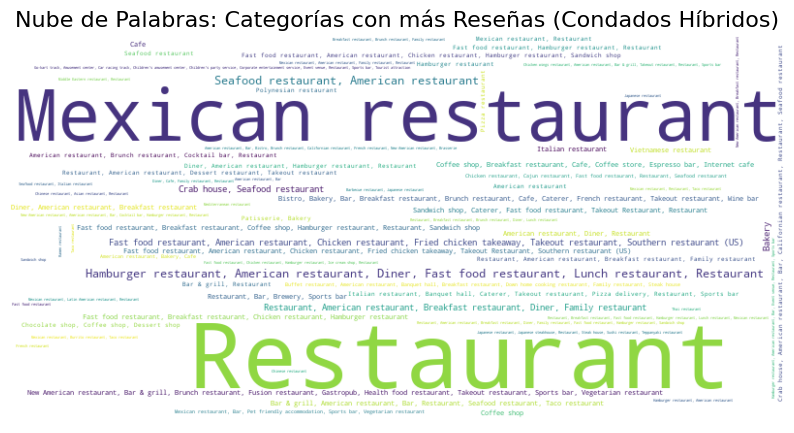

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtrar las reseñas por los condados híbridos
df_hibridos = df_metadatos[df_metadatos['county'].isin(condados_hibridos)]

# Agrupar por categoría y sumar las reseñas
category_reseñas_dict_hibridos = df_hibridos.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras para condados híbridos
wordcloud_hibridos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_hibridos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_hibridos, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Categorías con más Reseñas (Condados Híbridos)', fontsize=16)
plt.show()


**Ahora analicemos los condados exclusivamente "turísticos"**

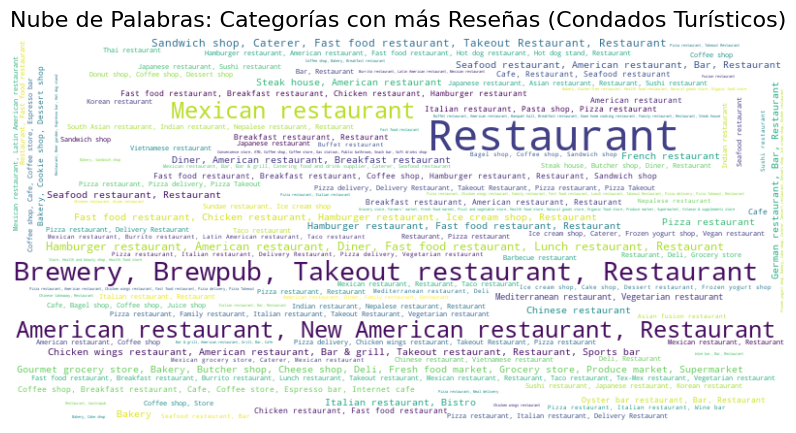

In [73]:
# Filtrar las reseñas por los condados turísticos
df_turisticos = df_metadatos[df_metadatos['county'].isin(condados_turisticos)]

# Agrupar por categoría y sumar las reseñas
category_reseñas_dict_turisticos = df_turisticos.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras para condados turísticos
wordcloud_turisticos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_turisticos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_turisticos, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Categorías con más Reseñas (Condados Turísticos)', fontsize=16)
plt.show()


**Por útimo, veamos los condados exclusivamente "industriales"**.

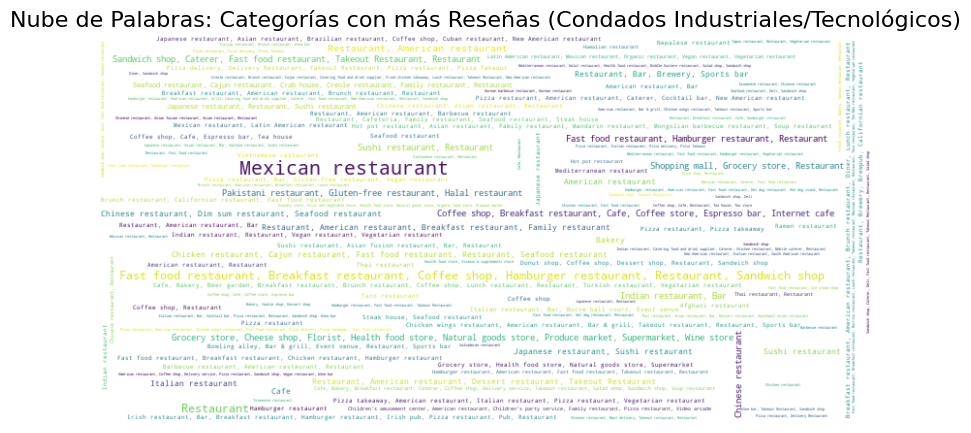

In [74]:
# Filtrar las reseñas por los condados industriales/tecnológicos
df_industriales = df_metadatos[df_metadatos['county'].isin(condados_industriales)]

# Agrupar por categoría y sumar las reseñas
category_reseñas_dict_industriales = df_industriales.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras para condados industriales/tecnológicos
wordcloud_industriales = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_industriales)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_industriales, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Categorías con más Reseñas (Condados Industriales/Tecnológicos)', fontsize=16)
plt.show()


Con este análisis podemos obtener algunas conclusiones.
- La comida mexicana tiene gran popularidad en el Estado de California.
Ya hemos referido el contexto demográfico de la población de habla hispana, y su injerencia en el mercado gastronómico no es ajena a tal suceso.
La cantidad de reseñas es un índicio de popularidad. Sin embargo, la popularidad de estos comercios no se explican sólo en la cantidad de habitantes de origen hispano; sino que se puede visualizar un gusto generalizado por la comida mexicana. La cercanía territorial con latinoamérica suele motivar a los ciudadanos locales a adoptar culturas vecinas. También podemos presumir que hay gran cantidad de turistas de habla hispana, que puede continuar agigantando la tendencia. 

- Las comunidades marcan tendencias gastronómicas.
Sería injusto limitar el análisis cultural a los ciudadanos, turistas (y consumidores en general) con relación hispana: contamos con un subgrupo asiático (comida china, india, japonesa y otras) que tiene una fuerte presencia. También observamos que, solitariamente, se destaca la cocina italiana (o trattorias).
Un caso curioso es la 'cocina americana' (o 'american restaurant'): tiene una fuerte presencia en este análisis de popularidad, sobre todo en los sectores industriales o híbridos. El problema que tiene es que, a partir de una observación más cercana, ésta categoría suele llevar a la confusión: contempla tanto la cocina americana (grill, cocina a fuego alto, platos eminentemente occidentales) con el servicio 'estilo americano' (emplatado en cocina).

- Servicios de mesa prevalecen en condados "industriales" e "híbridos".
- Comidas rápidas en zonas turísticas
- Comidas saludables en zonas industriales


In [ ]:
#avg_rating: promedio de reseñas

In [49]:
df_metadatos

Index(['gmap_id', 'name', 'address', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'state', 'relative_results',
       'Service options', 'clasificacion', 'address_depurada', 'city',
       'county'],
      dtype='object')